## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','AGEP','JWMNP','SEX','SCHL','COW','DPHY','DEYE','DREM','DOUT','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,AGEP,JWMNP,SEX,SCHL,COW,DPHY,DEYE,DREM,DOUT,RAC1P,HINCP,NP,VEH,BLD,ACCESS
4,6,9.0,1,21.0,1.0,2.0,2,2.0,2.0,1,9.0,3,3.0,2.0,1.0
5,6,4.0,2,21.0,3.0,2.0,2,2.0,2.0,1,9.0,3,3.0,2.0,1.0
7,7,6.0,1,19.0,3.0,2.0,2,2.0,2.0,1,3.0,2,3.0,1.0,3.0
8,6,2.0,2,16.0,1.0,2.0,2,2.0,2.0,1,3.0,2,3.0,1.0,3.0
9,4,0.0,1,5.0,1.0,2.0,2,2.0,2.0,9,1.0,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,4,8.0,1,21.0,1.0,2.0,2,2.0,2.0,6,3.0,3,2.0,2.0,1.0
356010,3,9.0,1,18.0,1.0,2.0,2,2.0,2.0,1,6.0,4,2.0,3.0,1.0
356013,5,9.0,1,18.0,1.0,2.0,2,2.0,2.0,1,6.0,3,4.0,2.0,1.0
356014,5,6.0,2,19.0,1.0,2.0,2,2.0,2.0,1,6.0,3,4.0,2.0,1.0


In [3]:
HH_IDX = pums_data_p.shape[1] - 1  # Index of household variables start
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable, as well as numeric encodings per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [9, 10, 2, 24, 8, 2, 2, 2, 2, 9, 10, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]
HH_IDX_MANIFEST = sum(CAT_LENGTHS[:HH_IDX])

# Add columns for original household variables; these will be used as conditionals
model_data_df = pd.concat([model_data_df, model_data_df.iloc[:,HH_IDX_MANIFEST:]], axis=1)

# Preview data that will be fed into model
model_data_df

,AGEP__1,AGEP__2,AGEP__3,AGEP__4,AGEP__5,AGEP__6,AGEP__7,AGEP__8,AGEP__9,JWMNP__0.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
356010,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
356013,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
356014,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.03)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 4506 samples


## Set Parameters and Define Model

In [6]:
# Hyperparameters
BATCH_SIZE = 512
EPOCHS = 100
LATENT_DIM = 6
HIDDEN_DIM = 32
KL_WEIGHT = .05

## Training

In [7]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [8]:
start_time = time.time()

# Train
vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])

print(f"--- {time.time() - start_time} seconds ---")

Epoch 1/100
9/9 [==============================] - 0s 33ms/step - tot_loss: 26.2796 - rec_loss: 26.2445 - kl_loss: 0.0352
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - tot_loss: 24.0116 - rec_loss: 23.9409 - kl_loss: 0.0707
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 21.7484 - rec_loss: 21.5951 - kl_loss: 0.1534
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 19.7379 - rec_loss: 19.4860 - kl_loss: 0.2519
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 18.3337 - rec_loss: 18.0158 - kl_loss: 0.3179
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 17.4318 - rec_loss: 17.1122 - kl_loss: 0.3196
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 16.7985 - rec_loss: 16.5212 - kl_loss: 0.2774
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 16.3467 - rec_loss: 16.1194 - kl_loss: 0.2273
Epoch 9/100
9/9 [==============

9/9 [==============================] - 0s 4ms/step - tot_loss: 7.7206 - rec_loss: 7.2773 - kl_loss: 0.4433
Epoch 69/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 7.6660 - rec_loss: 7.2204 - kl_loss: 0.4456
Epoch 70/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 7.6066 - rec_loss: 7.1593 - kl_loss: 0.4473
Epoch 71/100
9/9 [==============================] - 0s 11ms/step - tot_loss: 7.5542 - rec_loss: 7.1053 - kl_loss: 0.4488
Epoch 72/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 7.5126 - rec_loss: 7.0624 - kl_loss: 0.4502
Epoch 73/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 7.4618 - rec_loss: 7.0094 - kl_loss: 0.4524
Epoch 74/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 7.4179 - rec_loss: 6.9640 - kl_loss: 0.4539
Epoch 75/100
9/9 [==============================] - 0s 4ms/step - tot_loss: 7.3698 - rec_loss: 6.9147 - kl_loss: 0.4551
Epoch 76/100
9/9 [==============================] - 

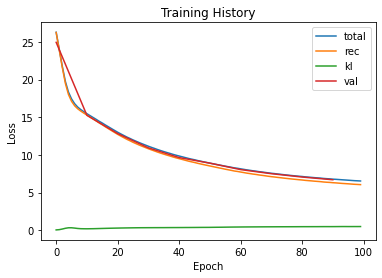

In [9]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl","val"], loc="upper right")
plt.show()

## Testing

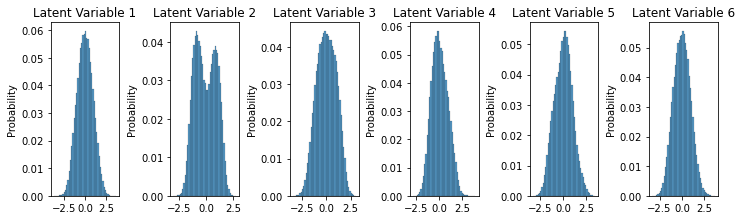

In [10]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [11]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 6.523324489593506


In [12]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

<ipython-input-13-769d7161711e>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=20)


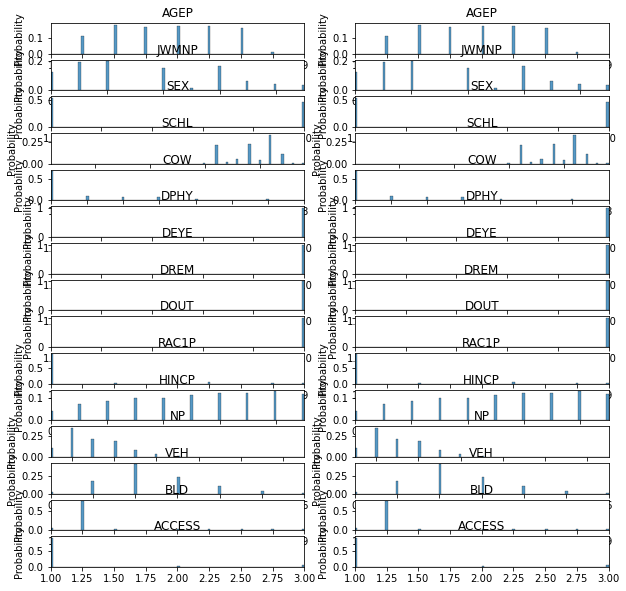

In [13]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=20)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(test_results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [14]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# How many variables represent each household
HH_DIM = 5

In [15]:
# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

In [16]:
# How many synthetic households to fill
POP_SIZE = len(synth_hh_ohe_df)

# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

start_time = time.time()

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])

print(f"--- {time.time() - start_time} seconds ---")

--- 7.119609832763672 seconds ---


In [17]:
# Convert the test results from logits to values
synth_p_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
synth_p_df.columns = VAR_NAMES

# Assign the control variables from the synthetic households to individuals (replace what came from the model)
for var in HH_VAR_NAMES[1:]:
    synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

# Save the synthesized persons
synth_p_df.to_csv('data/synthetic_populations/wa_persons.csv', index=False)
synth_p_df

,AGEP,JWMNP,SEX,SCHL,COW,DPHY,DEYE,DREM,DOUT,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,5,6.0,2,21.0,4.0,2.0,2,2.0,2.0,1,8.0,5,4.0,2.0,1.0
1,6,0.0,1,19.0,1.0,2.0,2,2.0,2.0,1,8.0,5,4.0,2.0,1.0
2,2,6.0,2,20.0,1.0,2.0,2,2.0,2.0,1,8.0,5,4.0,2.0,1.0
3,6,2.0,2,16.0,1.0,2.0,2,2.0,2.0,1,8.0,5,4.0,2.0,1.0
4,4,6.0,2,21.0,1.0,2.0,2,2.0,2.0,1,8.0,5,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255883,4,8.0,1,16.0,1.0,2.0,2,2.0,2.0,1,2.0,6,1.0,2.0,1.0
255884,3,2.0,1,17.0,1.0,2.0,2,2.0,2.0,1,2.0,6,1.0,2.0,1.0
255885,3,2.0,1,17.0,1.0,2.0,2,2.0,2.0,6,2.0,6,1.0,2.0,1.0
255886,3,1.0,2,19.0,1.0,2.0,2,2.0,2.0,3,2.0,6,1.0,2.0,1.0


<ipython-input-18-370640e01e01>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=40)


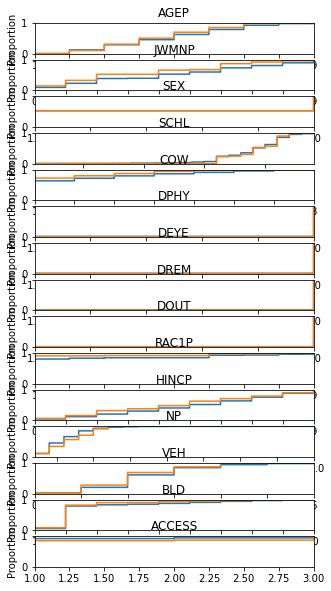

In [18]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=40)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_p_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

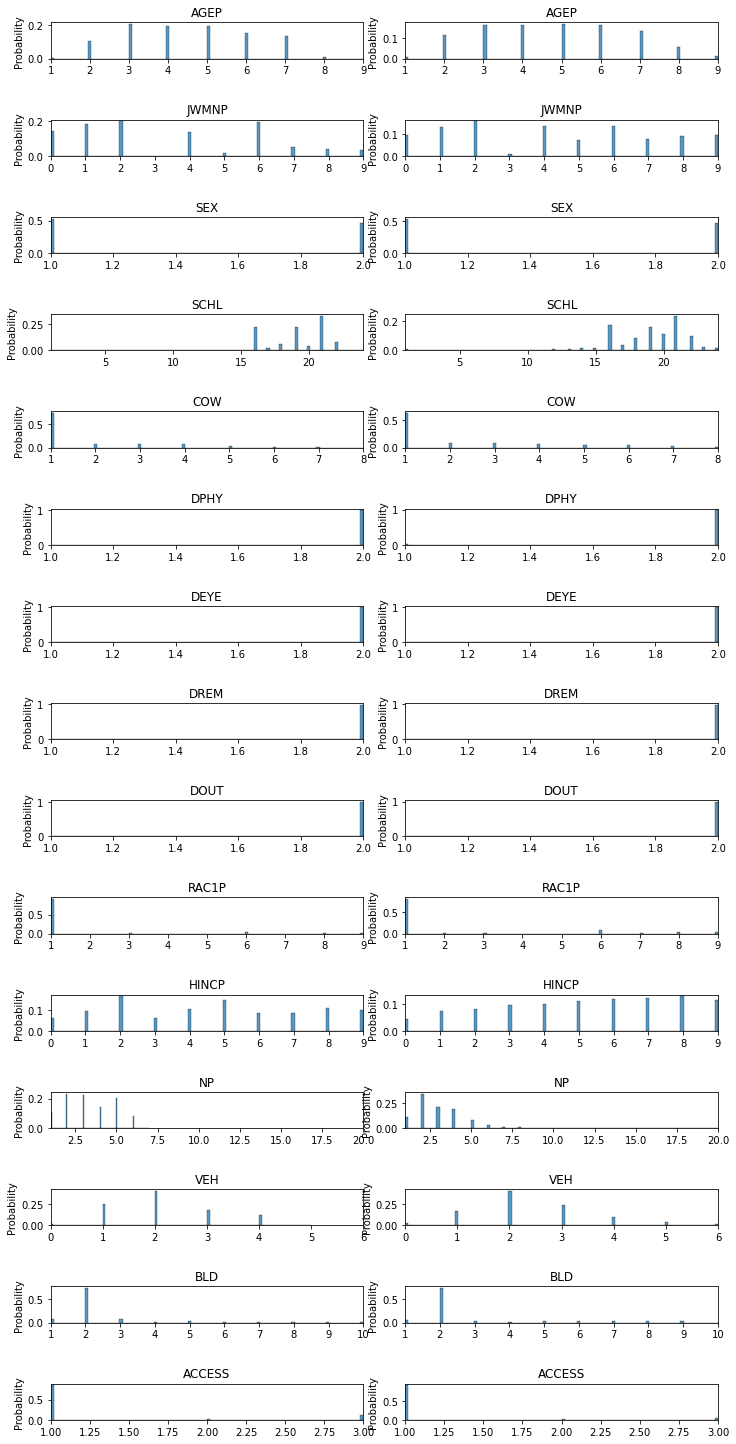

In [19]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,20))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(synth_p_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

In [20]:
SRMSE.calculateSRMSE(synth_p_df, pums_data)
SRMSE.calculateBivariateSRMSE(synth_p_df, pums_data)

Univariate (marginal) SRMSE: 0.32338197357779713
Bivariate (joint) SRMSE: 0.029972630885451986


0.029972630885451986